# A Companion Notebook to *Equation of State Calculations by Fast Computing Machines* by *Metropolis et al.*

### Alex Kerr

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import math

This notebook serves as a paraphrasing of Section II of the titular paper.  This paper by *Metropolis et al.* develops a method to calculate properties of materials composed of interacting molecules via Monte Carlo integration.  The authors go forward assuming classical statistics, 2D materials, and spherically-symmetric two-body potentials.

**Original paper**:

Equation of State Calculations by Fast Computing Machines
Metropolis, Nicholas and Rosenbluth, Arianna W. and Rosenbluth, Marshall N. and Teller, Augusta H. and Teller, Edward, The Journal of Chemical Physics, 21, 1087-1092 (1953), DOI:http://dx.doi.org/10.1063/1.1699114

##General Method for Arbitrary Potential

The authors resort to a square spatial environment of side length $ L $ with periodic boundary conditions.  Therefore it is important to define $ d_{AB} $ as the shortest radial distance between particles $ A $ and $ B $ to compute the interations between them.  For example, particles at opposite corners of the square space are not $ \sqrt2  L $ apart but rather extremely close ( $ d_{AB} < < 1 $ ).  Since the particles' locations will be well-defined we can calculate the potential energy of the system: $$ E = \frac{1}{2} \sum_i \sum_{j \neq i} V_{ij} (r_{ij} ) $$

It is understood that $ r_{ij} $ is the shortest distance between particles $i$ and $j$ ($d_{ij}$).

We can calculate the equilibrium value of quantity $ A $ by: $$ \bar A = \frac{1}{\mathcal{Z}} \int A \exp(-E/kT) d^{2N}p d^{2N} q $$ where $ \mathcal{Z} $ is the familiar canonical partition function which serves as the normalization.  Since the interparticular potentials are velocity-independent the momenta integral is cancelled off and we are left with an integration that only depends on the configuration of the particles.  The impracticality of performing the integral as written above is the impetus for this paper.  The authors refer to Monte Carlo integration instead.

One way to do the integration would be to randomly place your $ N $ particles in the space, calculate the energy $ E $ of the system, then weigh the configuration by $ \exp(-E/kT) $.  You would need to keep a running total of both the numerator and denominator of the above equation.  After a satisfactory number of iterations you can enjoy your Monte Carlo approximation.  However this method may not be the most effective since tightly-packed configurations (corresponding to high $ E $) are presumably equally likely to be appear in each of the iterations but do not contribute much to your running sum as $ \exp(-E/kT) $ would be low.  This is where the authors' modified Monte Carlo approach comes into play: configurations are *chosen* with probability $ \exp(-E/kT) $ and *weighted* evenly.

The method is as follows:

1. Begin with $ N $ particles in some initial configuration like a discrete lattice.

2. Loop through each particle.  During each iteration:

    1. Change the particle's x, y - positions according to the following: $ X \rightarrow X + \alpha \xi_1 $, $ Y \rightarrow Y + \alpha \xi_2 $ where $ \alpha $ is some predefined max allowed displacement and $ \xi_i $ is a uniformly distributed random variable between $ -1 $ and $ 1 $.  The effect is each particle is allowed to move within a square centered around its original position.
    
    2. Calculate the energy of the new configuration ($ E_{n+1}$).
    
    3. Compare $E_{n+1}$ to $E_{n}$.  There are two possible outcomes:
    
        * If  $E_{n+1} < E_{n}$:
        
            * Allow the particle move.
            
        * If $E_{n+1} > E_{n}$:
        
            *  Generate a new variable $ \xi_3 $ that is uniformly distributed from $0$ to $1$.  Calculate $ \exp(\Delta E /kT)$. If $ \xi_3 < \exp(\Delta E /kT) $ we allow the particle move.  If $ \xi_3 > \exp(\Delta E /kT) $ then we do not permit the move and we return the particle to its original position.
            
Whether or not each move is permitted we treat the system as a new configuration after each iteration in order to get the right averages.  With the above algorithm our new equation for $ \bar F $ becomes: $$ \bar F = \frac{1}{M} \sum^{M}_{n=1}  F_{n} $$ where $ F_{n} $ is the calculated quantity after the $n$th move.

The authors spend the next section proving the method works in the theory.

##Code for General Method

I will now present some code to demonstrate the Metropolis algorithm.

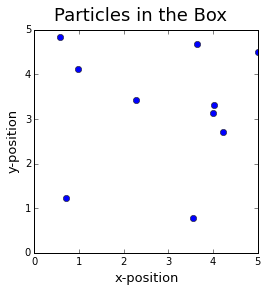

In [3]:
#define our square environment

L = 5.0     #side length of box
N = 10      #number of particles in box
kB = 1.0    #physical boltzmann constant
T = 25.0   #temperature of system

#define our initial configuration
#I want to use a box with its bottom left corner at the origin

def initialize_system():
    '''Populate the environment with randomly placed particles.
    '''
    
    posList = []
    
    for n in range(N):
        
        x = random.uniform(0,L)
        y = random.uniform(0,L)
        
        nPos = [x,y]
        
        posList.append(nPos)
        
    return posList

def plot_particles(posList):
    
    xList = []
    yList = []
    for i in posList:
        x = i[0]
        y = i[1]
        xList.append(x)
        yList.append(y)    
    
    
    fig = plt.figure()
    
    plt.plot(xList, yList, 'bo')
    
    fig.suptitle('Particles in the Box', fontsize=18)
    plt.axes().set_aspect('equal')
    plt.axis((0,L,0,L))
    plt.xlabel('x-position', fontsize=13)
    plt.ylabel('y-position', fontsize=13)
    
    plt.show()
    
initPosList = initialize_system()

plot_particles(initPosList)
        
        
    

In [4]:
#define some more functions we will need

def calculate_distance(posi, posj):
    '''Calculate the shortest distance between 2 positions, understanding periodic conditions
    '''
    #x, y positions of particle i,j
    xi = posi[0]
    yi = posi[1]
    xj = posj[0]
    yj = posj[1]
    
    #x,y distances between i and j as measured using box coordinates
    dx = xi - xj
    dy = yi - yj
    
    #if i and j are separated by more than half of the box length,
    #then their shortest distance is through the boundary
    if dx > L/2.0:
        dx = dx - L
    elif dx <= -L/2.0:
        dx = dx + L
    else:
        pass
        
    #similarly for y
    if dy > L/2.0:
        dy = dy - L
    elif dy <= -L/2.0:
        dx = dx + L
    else:
        pass
        
    rij = math.sqrt(dx*dx + dy*dy)
    
    return rij
    
def correct_position(posi):
    '''For each coordinate, if the position goes beyond the boundary we move it to the corresponding position
    on the other side of the system to enforce the periodic boundary conditions.
    '''
    
    xi = posi[0]
    yi = posi[1]
    
    if xi < 0:
        xi += L
    elif xi >= L:
        xi -= L
    else:
        pass
    
    if yi < 0:
        yi += L
    elif yi >= L:
        yi -= L
    else:
        pass
    
    newPosi = [xi,yi]
    
    return newPosi
    
def move_particle(posi):
    '''Return a position that is equally likely to be in a square centered on the original position.
    '''
    
    alpha = 1.0
    
    x = posi[0]
    y = posi[1]
    
    dx = random.uniform(-1.0, 1.0)
    dy = random.uniform(-1.0, 1.0)
    
    x += alpha*dx
    y += alpha*dy
    
    pos = [x,y]
    
    newPos = correct_position(pos)
    
    return newPos

def calculate_energy(posList):
    '''Calculate the energy of the configuration.  We will use a Coulombic potential
    with an effective cutoff function.
    '''
    
    #Coulombic potential terms
    k = 1.0
    fij = 2.0 #cutoff distance
    
    #running energy total
    e = 0.0
    
    icounter = 0
    
    for i in posList:
        
        vi = 0.0
        
        jcounter = 0
        
        for j in posList:
            
            if icounter != jcounter:
                #calculate distance
                
                rij = calculate_distance(i,j)
                
                #print rij
                
                if rij < fij:
                    #calculate energy
                    
                    vij = k/rij
                    
                    vi += vij
                    
                else:
                    #do nothing
                    pass
                    
            else:
                #do nothing
                pass
            
            jcounter += 1
            
        e += vi
        
        icounter += 1
        
    e = 0.5*e
    
    return e

Let's put it all together

In [5]:
#calculation for a quantity average

#define quantity to be calculated
calculate_a = calculate_energy     #function to calculate quantity of interest
aList = []                         #keep track of values for A

loop = 20  #number of times to loop through each particle

#initial system
ePrev = calculate_energy(initPosList)
posList = initPosList

#used to normalize the quantity calculation
mcounter = 0

for z in range(loop):
    
    icounter = 0
    for i in posList:
        
        testList = list(posList)
        
        posi = testList[icounter]
        
        newPos = move_particle(posi)
        
        testList[icounter] = newPos
        
        e = calculate_energy(testList)
        
        A = calculate_a(testList)    #redundant if A = E
        
        if e <= ePrev:
            
            posList = testList
            
        else:
            
            p = random.uniform(0,1)
            
            de = math.exp((ePrev - e)/kB/T)
            
            if p <= de:
                
                posList = testList
                
            else:
                pass
            
        ePrev = e
            
        aList.append(A)
            
        icounter += 1
        mcounter += 1
        


In [6]:
def plot_time(valueList):
    """Plot values against interation number/time
    """  
    
    tList = range(len(valueList))
    
    fig = plt.figure()
    
    plt.plot(tList, valueList, 'ro')
    
    fig.suptitle('Quantity vs. Iteration', fontsize=18)
    plt.xlabel('increment count', fontsize=13)
    plt.ylabel('quantity value', fontsize=13)
    
    plt.show()

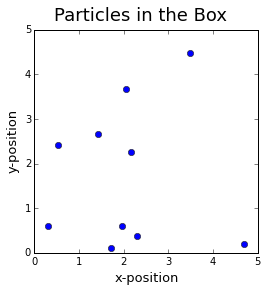

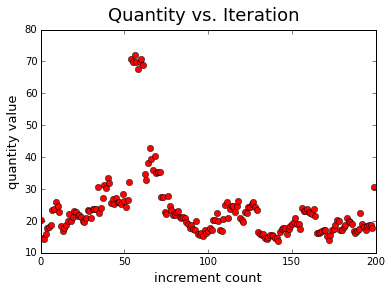

In [7]:
plot_particles(posList)
plot_time(aList)



Finally we actually peform our calculation.

In [8]:
M = float(mcounter)

aAverage = sum(aList)/M

print aAverage

23.5156567668


## Miscellaneous 

You may have noticed that step C from above can be condensed to one if-condition.  Since $ \exp(\Delta E /kT)$ corresponds to relative probability: 

$$ \exp(\Delta E /kT) = \exp(\frac{E_f - E_i}{kT}) = \frac{\exp(E_f /kT)}{\exp(E_i / kT)} = \frac{P(\text{final configuration})}{P(\text{initial configuration})} $$